# basic train demo1



### general import

In [1]:
import sys
sys.path.append('../')
from armoInclude import *
from armoTrain import basicModel

### get the data

In [2]:
def GenHarmonicData( numSignals: int, numSamples: int, samplingFreq: float, maxFreq: float, σ: float ) -> Tuple[torch.Tensor, torch.Tensor]:
    
    π = np.pi #<! Constant Pi

    vT   = torch.linspace(0, numSamples - 1, numSamples) / samplingFreq #<! Time samples
    vF   = maxFreq * torch.rand(numSignals)                             #<! Frequency per signal
    vPhi = 2 * π * torch.rand(numSignals)                               #<! Phase per signal
    
    # x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
    mX = torch.sin(2 * π * vF[:, None] @ vT[None, :] + vPhi[:, None])       ## @ is matrix multiplication in PyTorch
    mX = mX + σ * torch.randn(mX.shape) #<! Add noise

    return mX, vF


In [3]:
numSignalsTrain = 1_000
numSignalsVal   = 100
numSignalsTest  = 100
numSamples      =  500 #<! Samples in Signal
samplingFreq    = 100.0 #<! [Hz]
maxFreq         = 10.0  #<! [Hz]
σ               = 0.1 #<! Noise Std

mXTrain, vYTrain    = GenHarmonicData(numSignalsTrain, numSamples, samplingFreq, maxFreq, σ) #<! Train Data
mXVal, vYVal        = GenHarmonicData(numSignalsVal, numSamples, samplingFreq, maxFreq, σ)   #<! Validation Data
mXTest, vYTest      = GenHarmonicData(numSignalsTest, numSamples, samplingFreq, maxFreq, σ)  #<! Test Data



### data preprocess

In [4]:
#none 

### Transforms

In [5]:
dsTrain = torch.utils.data.TensorDataset(mXTrain.view(numSignalsTrain, 1, -1), vYTrain) 
dsVal   = torch.utils.data.TensorDataset(mXVal.view(numSignalsVal, 1, -1), vYVal)
dsTest  = torch.utils.data.TensorDataset(mXTest.view(numSignalsTest, 1, -1), vYTest)

### data loaders

In [6]:
batchSize   = 256
numWork     = 2 #<! Number of workers
nEpochs     = 20

dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)

### layers to model

In [7]:
def myModel( ) -> nn.Module:
    
    oModel = nn.Sequential(
        nn.Identity(),
        
        nn.Conv1d(in_channels = 1,   out_channels = 32,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 32,  out_channels = 64,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 64,  out_channels = 128, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size = 1),
        nn.Flatten          (),
        nn.Linear           (in_features = 256, out_features = 1),
        nn.Flatten          (start_dim = 0),
        )

    return oModel

In [8]:
oModel = myModel()
myTrain = basicModel(model=oModel)

### target HW

In [9]:
runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
oModel = oModel.to(runDevice)

### loss

In [10]:
hL = nn.MSELoss()
hL = hL.to(runDevice)


### score

In [11]:
hS = R2Score(num_outputs = 1)
hS = hS.to(runDevice)


### optimizer

In [12]:
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 1e-5)

### scheduler

In [13]:
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-4, total_steps = nEpochs)


### summary

In [14]:
myTrain.summary(dlTrain)

(==========================================================================================
 Layer (type:depth-idx)                   Output Shape              Param #
 Sequential                               [256]                     --
 ├─Identity: 1-1                          [256, 1, 500]             --
 ├─Conv1d: 1-2                            [256, 32, 490]            384
 ├─MaxPool1d: 1-3                         [256, 32, 245]            --
 ├─ReLU: 1-4                              [256, 32, 245]            --
 ├─Conv1d: 1-5                            [256, 64, 235]            22,592
 ├─MaxPool1d: 1-6                         [256, 64, 117]            --
 ├─ReLU: 1-7                              [256, 64, 117]            --
 ├─Conv1d: 1-8                            [256, 128, 107]           90,240
 ├─MaxPool1d: 1-9                         [256, 128, 53]            --
 ├─ReLU: 1-10                             [256, 128, 53]            --
 ├─Conv1d: 1-11                           

In [15]:
myTrain.verify( dlTrain, dlVal, oOpt, nEpochs , batchSize , hL, hS, oSch = oSch)


numEpoch = 20 ; batchSize = 256
Train: 
    dlTrain: iter tX shape   = torch.Size([256, 1, 500]) 
    dlTrain: tensor[0].shape = torch.Size([1000, 1, 500])
    dlTrain: iter vY ; shape = torch.Size([256])
    dlTrain: tensor[1].shape = torch.Size([1000])
    dlTrain: len = 4
+++ last layer size [256] == vY shape [256] ; PASS 
Val: 
    dlVal  : tensor[0].shape = torch.Size([100, 1, 500])
    dlVal  : tensor[1].shape = torch.Size([100])


### train

In [16]:
nEpochs = 10
# myTrain = basicModel(CheckpointFile='BestModel.pt')
trained = myTrain.TrainModel(dlTrain, dlVal, oOpt, nEpochs, hL, hS, oSch = oSch)

Epoch    1 / 10 | Train Loss: 33.852 | Val Loss: 32.712 | Train Score: -3.119 | Val Score: -2.721 | Epoch Time:  1.68 |
Epoch    2 / 10 | Train Loss: 33.327 | Val Loss: 31.830 | Train Score: -3.062 | Val Score: -2.620 | Epoch Time:  1.57 |
Epoch    3 / 10 | Train Loss: 31.854 | Val Loss: 29.050 | Train Score: -2.875 | Val Score: -2.304 | Epoch Time:  1.42 |
Epoch    4 / 10 | Train Loss: 26.243 | Val Loss: 16.542 | Train Score: -2.203 | Val Score: -0.881 | Epoch Time:  1.40 |
Epoch    5 / 10 | Train Loss: 10.730 | Val Loss: 13.632 | Train Score: -0.310 | Val Score: -0.550 | Epoch Time:  1.41 |
Epoch    6 / 10 | Train Loss:  7.098 | Val Loss:  5.281 | Train Score:  0.132 | Val Score:  0.399 | Epoch Time:  1.56 |
Epoch    7 / 10 | Train Loss:  4.555 | Val Loss:  2.148 | Train Score:  0.447 | Val Score:  0.756 | Epoch Time:  1.58 |
Epoch    8 / 10 | Train Loss:  1.847 | Val Loss:  1.709 | Train Score:  0.775 | Val Score:  0.806 | Epoch Time:  1.06 |
Epoch    9 / 10 | Train Loss:  0.876 | V

### train graph

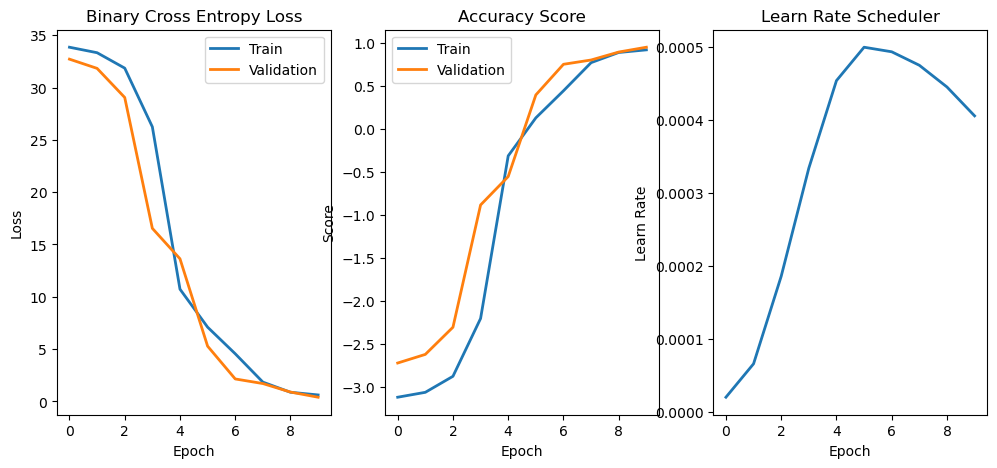

In [17]:
myTrain.plotTrainResults()

## Test after train

In [18]:
myTrain.evaluate_test_data(testData = dlTest ,loss_fn=hL)

Test Loss: 0.45408278703689575


0.45408278703689575

## inference

In [19]:
test_x_data = mXTest.view(numSignalsTest, 1, -1)
eval_result = myTrain.inference(test_x_data)
print(f"test_x_data[1] = {test_x_data[1] }")      
print(f"eval_result[1] = {eval_result[1] }")      

test_x_data[1] = tensor([[ 0.4330,  0.7409,  0.9864,  0.8648,  0.9802,  1.0151,  0.9968,  0.6278,
          0.5286, -0.0102, -0.0471, -0.2660, -0.6368, -0.6808, -1.0382, -0.9018,
         -0.9641, -0.8658, -0.6911, -0.4572, -0.0642,  0.0533,  0.3766,  0.7291,
          0.8222,  0.9452,  1.0186,  0.9629,  0.7092,  0.6923,  0.4476,  0.1281,
         -0.0940, -0.5585, -0.6190, -0.8307, -0.8227, -0.9966, -1.0272, -0.9184,
         -0.4482, -0.6749, -0.1138,  0.0891,  0.1612,  0.7073,  0.8699,  0.8968,
          0.8628,  0.7877,  0.6681,  0.5789,  0.5575,  0.2654, -0.0808, -0.2733,
         -0.6051, -0.8126, -0.8864, -0.9784, -1.0858, -0.7918, -0.7376, -0.3481,
         -0.2633,  0.0252,  0.1941,  0.6670,  0.8539,  1.0558,  0.9254,  0.9715,
          0.9654,  0.5713,  0.5892,  0.3235,  0.0392, -0.4046, -0.3504, -0.7864,
         -0.7648, -1.0350, -1.0050, -0.9959, -0.9249, -0.4418, -0.4826, -0.0036,
          0.1615,  0.5309,  0.7537,  0.9156,  0.9637,  0.9561,  0.9966,  0.6165,
          0